# Patient Diabetes Prediction

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. 

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Imports

In [1]:
import os
os.system("pip install katonic[ml]")


[notice] A new release of pip available: 22.3 -> 23.3
[notice] To update, run: pip install --upgrade pip


0

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from itertools import cycle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from katonic.ml.classification import Classifier

## Data Prepration

In [3]:
exp_name = 'diabetes_prediction3'

In [4]:
# loading diabetes data from github
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The datasets consists of several medical predictor variables and one target variable **Outcome**. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [8]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
   
    return summary

In [9]:
resumetable(df)

Dataset Shape: (768, 9)


,Name,dtypes,Missing,Uniques
0,Pregnancies,int64,0,17
1,Glucose,int64,0,136
2,BloodPressure,int64,0,47
3,SkinThickness,int64,0,51
4,Insulin,int64,0,186
5,BMI,float64,0,248
6,DiabetesPedigreeFunction,float64,0,517
7,Age,int64,0,52
8,Outcome,int64,0,2


**To fill these missing values the data distribution needs to be understood against the target.**

## Exploratory Data Analysis

Let's check the skewness of each of the columns.

In [10]:
for col in df.drop('Outcome', axis = 1).columns:
    print(f"Skewness for the column {col} is {df[col].skew()}")

Skewness for the column Pregnancies is 0.9016739791518588
Skewness for the column Glucose is 0.17375350179188992
Skewness for the column BloodPressure is -1.8436079833551302
Skewness for the column SkinThickness is 0.10937249648187608
Skewness for the column Insulin is 2.272250858431574
Skewness for the column BMI is -0.42898158845356543
Skewness for the column DiabetesPedigreeFunction is 1.919911066307204
Skewness for the column Age is 1.1295967011444805


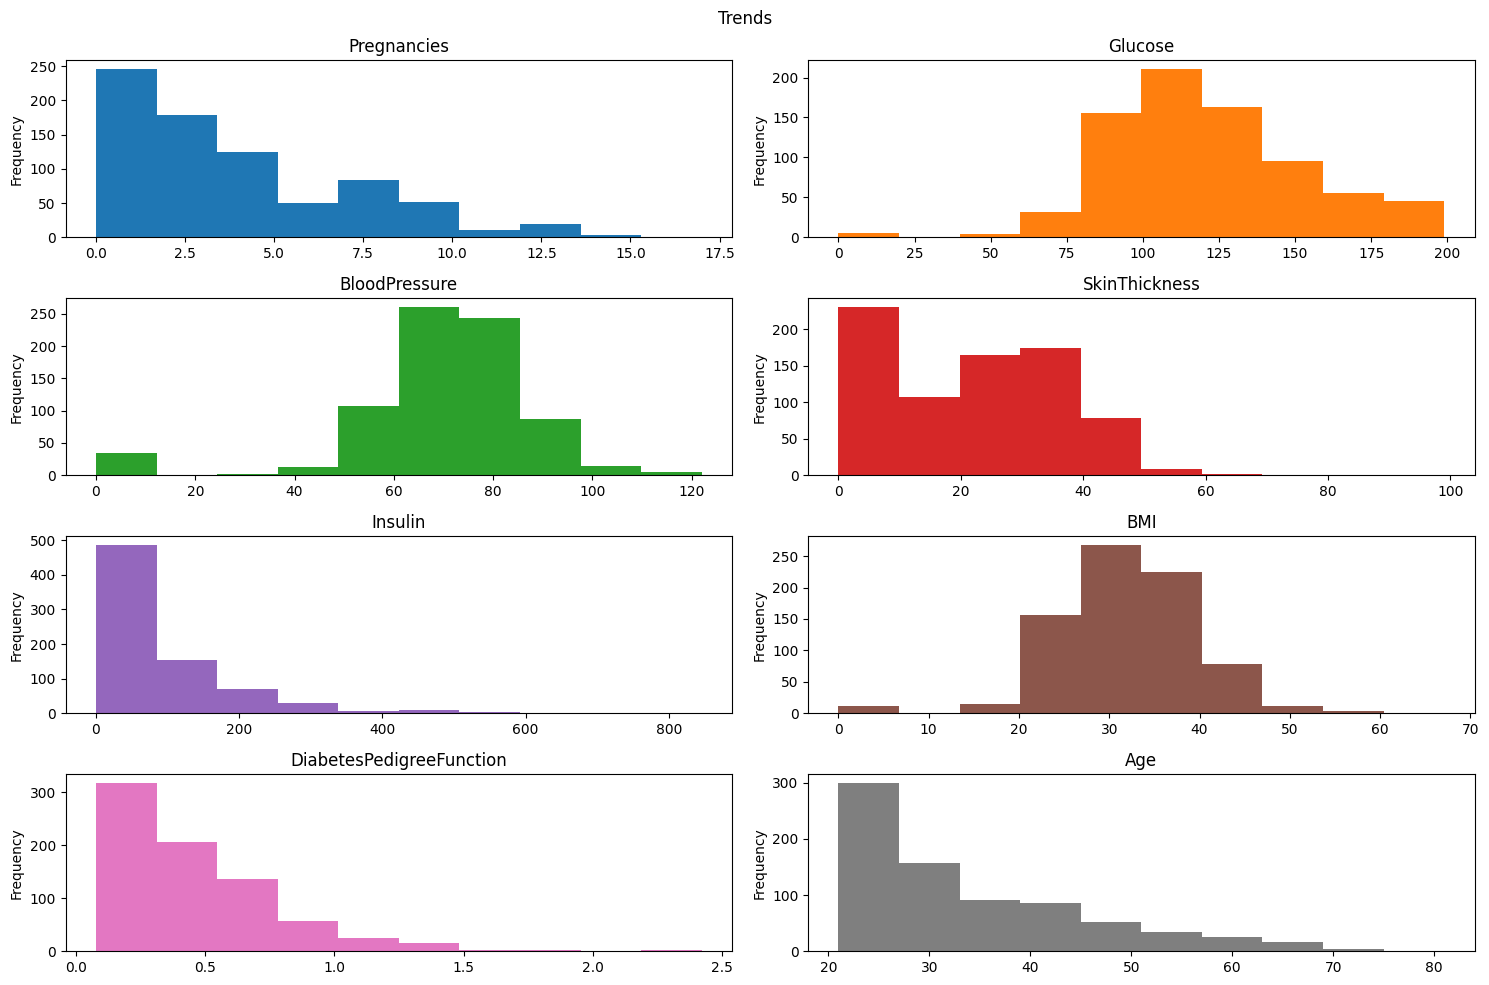

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()
columns = df.drop('Outcome', axis = 1).columns
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for ax_idx, col in enumerate(columns):
    df[col].plot(kind = 'hist', ax = axes[ax_idx], title = col, color = next(color_cycle))
plt.suptitle('Trends')
plt.tight_layout()
plt.show()

- Columns like `Pregnancies`, `Glucose`, `BloodPressure`, `SkinThickness` and `BMI` are not that much skewed. **We can fill null values with the mean for these columns.**
- Columns like `Insulin` and `DiabetesPedigreeFunction`,**We have to replace them with median due to the effect of skewness.**

#### Filling null values

In [12]:
# Filling null values with the median.
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].median()) 

# Filling null values with the mean.
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    df[col] = df[col].fillna(df[col].mean())

In [13]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

All null values are taken care of now

##### We would know what is the effect of Age on the Outcome because we have heard that as the age increases, the chances of diabetes also commonly increases.

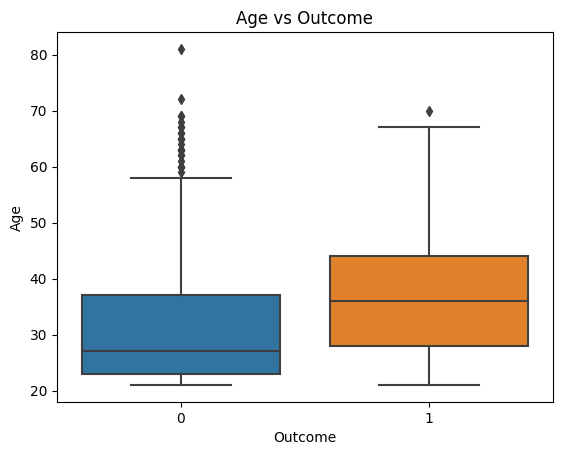

In [14]:
sns.boxplot(x = 'Outcome', y = 'Age', data = df)
plt.title('Age vs Outcome')
plt.show()

Yes, we were right, The median of the age of diabetic people is greater than that of non-diabetic people.

##### The effect of Blood Pressure on the Outcome.

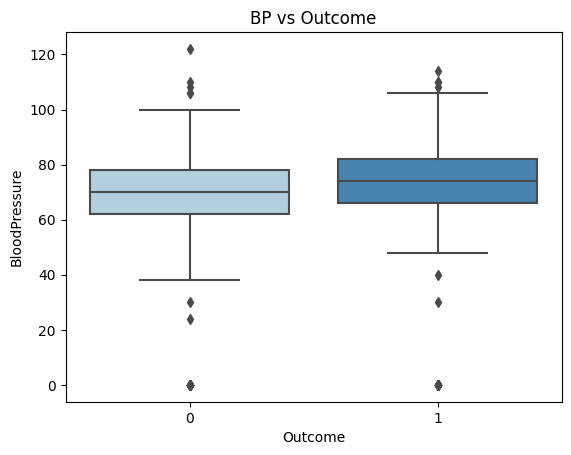

In [15]:
sns.boxplot(x = 'Outcome', y = 'BloodPressure', data = df, palette = 'Blues')
plt.title('BP vs Outcome')
plt.show()

The median of the BloodPressure of diabetic people lies close to the 75th Percentile of non-diabetic people.

##### The relationship between age and BP

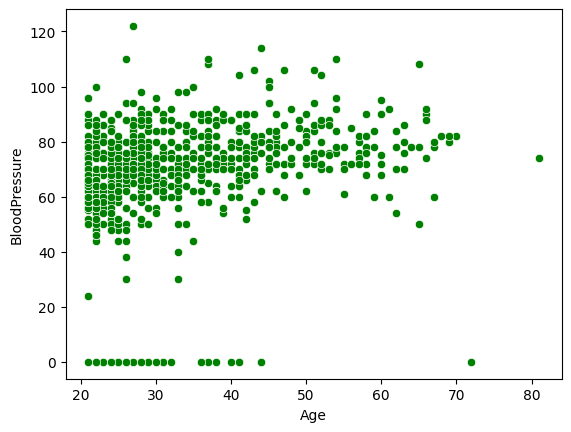

In [16]:
sns.scatterplot(x='Age',y='BloodPressure', data=df, color = 'green');

As the age increases, generally the Blood Pressure also increases

A **correlation matrix** is a table showing correlation coefficients between sets of variables.

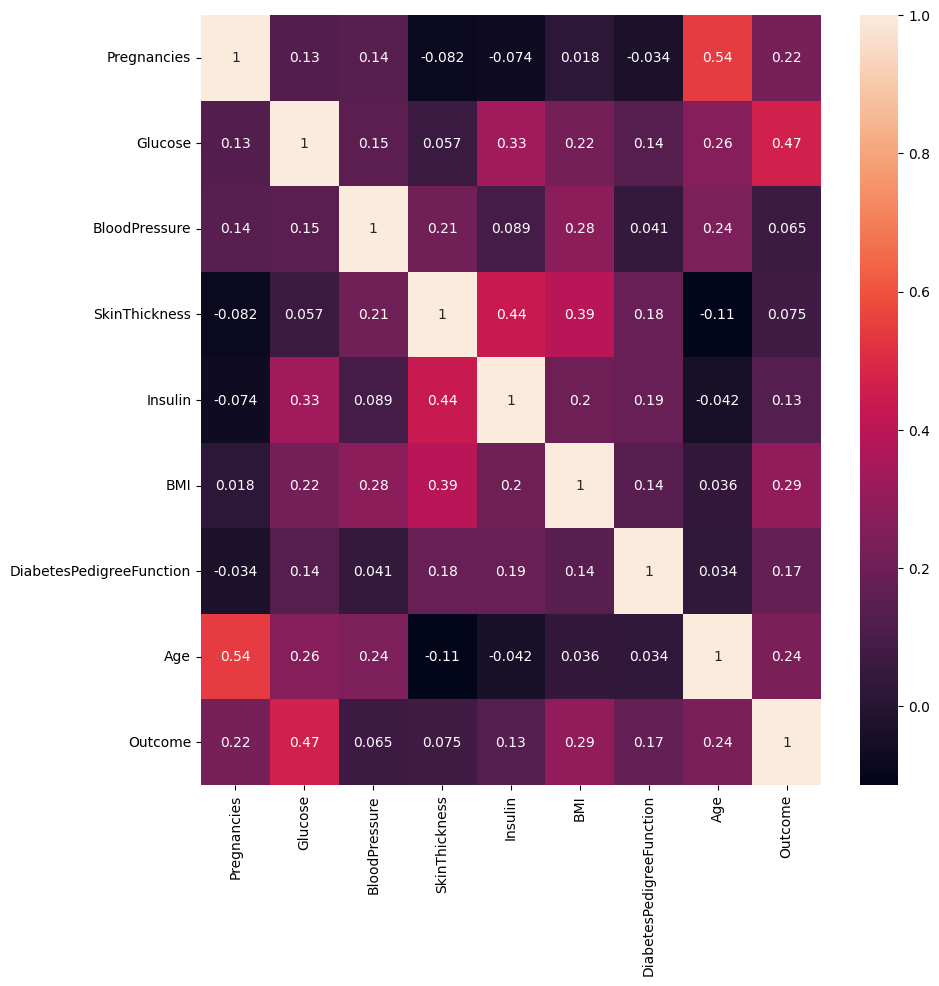

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True);

- From the above heatmap, we can observe that all the features are weakly correlated, so that removes multicollinearity out of equation.

Multicollinearity (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. Models like Logistic Regression assumes the presence of non-collinearity among the features, if multicollinearity is present it can lead to the bad performance of such models

## Dataset Splitting

In [18]:
x = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=98)

## Features Scaling

In [20]:
sc = StandardScaler()
X_train =  pd.DataFrame(sc.fit_transform(X_train),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
X_test = pd.DataFrame(sc.fit_transform(X_test),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])

## Classification Models

#### Create object of Classifier class

In [21]:
clf = Classifier(X_train,X_test,y_train,y_test, exp_name)

In [22]:
exp_id = clf.id
print("experiment name : ", clf.name)
print("experiment location : ", clf.location)
print("experiment id : ", clf.id)
print("experiment status : ", clf.stage)

experiment name :  diabetes_prediction3
experiment location :  s3://models/3
experiment id :  3
experiment status :  active


#### Clear previous runs

In [23]:
run_list = clf.search_runs(exp_id)['run_id'].tolist()
if run_list:
    clf.delete_run_by_id(run_list)

### Logistic Regression

#### Set up parameters for tuning

In [24]:
params={
'solver':{
    'values': ['liblinear', 'lbfgs', 'sag'],
    'type': 'categorical'
},
    'C':{
        'low': 0.6,
        'high': 1.0,
        'type': 'float'
    }
}

In [25]:
clf.LogisticRegression(True, params=params)

[I 2023-10-17 15:51:02,227] A new study created in memory with name: no-name-6899e6d0-dee7-4936-9302-eb5738a255a7
[I 2023-10-17 15:51:04,106] Trial 0 finished with value: 0.7523076923076923 and parameters: {'solver': 'liblinear', 'C': 0.6}. Best is trial 0 with value: 0.7523076923076923.
[I 2023-10-17 15:51:05,974] Trial 1 finished with value: 0.7523076923076923 and parameters: {'solver': 'liblinear', 'C': 0.8}. Best is trial 0 with value: 0.7523076923076923.
[I 2023-10-17 15:51:07,739] Trial 2 finished with value: 0.7523076923076923 and parameters: {'solver': 'lbfgs', 'C': 0.6}. Best is trial 0 with value: 0.7523076923076923.
[I 2023-10-17 15:51:09,588] Trial 3 finished with value: 0.7523076923076923 and parameters: {'solver': 'sag', 'C': 0.7}. Best is trial 0 with value: 0.7523076923076923.
[I 2023-10-17 15:51:11,373] Trial 4 finished with value: 0.7523076923076923 and parameters: {'solver': 'lbfgs', 'C': 0.8}. Best is trial 0 with value: 0.7523076923076923.


Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7523076923076923
  Params: 
    solver: liblinear
    C: 0.6


### Decision Tree

#### Set up parameters for tuning

In [26]:
params = {
'max_depth': {
    'low': 8,
    'high': 15,
    'type': 'int'
    },
'criterion':{
    'values': ['gini', 'entropy'],
    'type': 'categorical'
    },
'splitter':{
    'values': ['best', 'random'],
    'type': 'categorical'
    },
'min_samples_split': {
    'low': 2,
    'high': 5,
    'type': 'int'
    },
'min_samples_leaf':{
    'low': 1,
    'high': 5,
    'type': 'int'
    },
'max_features':{
    'values': ['auto', 'sqrt', 'log2'],
    'type': 'categorical'
    }
}

In [27]:
clf.DecisionTreeClassifier(True, params=params)

[I 2023-10-17 15:51:13,448] A new study created in memory with name: no-name-58a43f4a-2ce7-433b-b9d5-128b20e075cb
[I 2023-10-17 15:51:15,551] Trial 0 finished with value: 0.6871153846153846 and parameters: {'max_depth': 12, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6871153846153846.
[I 2023-10-17 15:51:17,501] Trial 1 finished with value: 0.6726923076923077 and parameters: {'max_depth': 14, 'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'auto'}. Best is trial 0 with value: 0.6871153846153846.
[I 2023-10-17 15:51:19,361] Trial 2 finished with value: 0.6334615384615384 and parameters: {'max_depth': 14, 'criterion': 'entropy', 'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6871153846153846.
[I 2023-10-17 15:51:21,290] Trial 3 finished with value: 0.66

Number of finished trials:  5
Best trial:
  auc_roc_score:  0.6871153846153846
  Params: 
    max_depth: 12
    criterion: entropy
    splitter: random
    min_samples_split: 2
    min_samples_leaf: 3
    max_features: log2


### Random Forest

#### Set up parameters for tuning

In [30]:
params = {
'n_estimators': {
    'low': 80,
    'high': 120,
    'step': 10,
    'type': 'int'
    },
'criterion':{
    'values': ['gini', 'entropy'],
    'type': 'categorical'
    },
'min_samples_split': {
    'low': 2,
    'high': 5,
    'type': 'int'
    },
'min_samples_leaf':{
    'low': 1,
    'high': 5,
    'type': 'int'
    }
}

In [31]:
clf.RandomForestClassifier(is_tune=True,n_trials=5, params=params)

2023/10/17 15:51:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpisvipm34/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:51:52,698] A new study created in memory with name: no-name-cffe91cb-dce2-4aab-94e2-d2d76b9c089b
2023/10/17 15:51:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp41v1p6ft/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:51:53,511] Trial 0 finished with value: 0.7178846153846155 and parameters: {'n_estimators': 120, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7178846153846155.
2023/10/17 15:51:54 WARNING mlflow.utils.env

Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7523076923076923
  Params: 
    n_estimators: 120
    criterion: entropy
    min_samples_split: 5
    min_samples_leaf: 3


### Gradient Boosting Classification

#### Setup parameters for tuning

In [32]:
params = {
'n_estimators': 90,
'loss':'deviance',
'learning_rate':{
    'low': 0.6,
    'high':1.0,
    'type': 'float'
    },
'min_samples_split': {
    'low': 2,
    'high': 5,
    'type': 'int'
    },
'min_samples_leaf':{
    'low': 1,
    'high': 5,
    'type': 'int'
    },
'max_depth': {
    'low': 2,
    'high': 4,
    'type': 'int'
    }
}

In [33]:
clf.GradientBoostingClassifier(is_tune=True, n_trials=10, params=params)

2023/10/17 15:51:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0ylljj3o/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:51:58,722] A new study created in memory with name: no-name-f26097fd-120d-422e-8b98-f7255813a513
2023/10/17 15:51:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8n70h8op/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:51:59,300] Trial 0 finished with value: 0.7238461538461539 and parameters: {'n_estimators': 90, 'loss': 'deviance', 'learning_rate': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}. Best is trial 0 with value: 0.7238461538461539.
2023/10/17 

Number of finished trials:  10
Best trial:
  auc_roc_score:  0.7675000000000001
  Params: 
    n_estimators: 90
    loss: deviance
    learning_rate: 0.6
    min_samples_split: 3
    min_samples_leaf: 2
    max_depth: 3


### AdaBoostClassifier

#### Setup parameters for tuning

In [34]:
params={
    'n_estimators':{
        'low':30,
        'high':60,
        'step':10,
        'type':'int'
    },
    'learning_rate':{
        'low':0.7,
        'high':1.0,
        'type':'float',
    },
    'algorithm':{
        'values':['SAMME', 'SAMME.R'],
        'type': 'categorical'
    }
}

In [35]:
clf.AdaBoostClassifier(True,params=params,random_state = 42)

2023/10/17 15:52:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5qiu62n1/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:04,538] A new study created in memory with name: no-name-557f5512-9b67-4e80-8802-d8babddf59b0
2023/10/17 15:52:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgy7vsrtw/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:05,022] Trial 0 finished with value: 0.7382692307692308 and parameters: {'n_estimators': 40, 'learning_rate': 0.7999999999999999, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.7382692307692308.
2023/10/17 15:52:05 WARNING mlflow.utils.environment: Enc

Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7382692307692308
  Params: 
    n_estimators: 40
    learning_rate: 0.7999999999999999
    algorithm: SAMME


### LightGBMClassifier

#### Setup parameters for tuning

In [36]:
params={
    'num_leaves':{
        'low':25,
        'high':35,
        'type':'int'
    },
    'learning_rate':{
        'low':0.1,
        'high':0.5,
        'type':'float'
    },
    'n_estimators':{
        'low':80,
        'high':120,
        'step':10,
        'type':'int'
    },
    'min_child_samples':{
        'low': 10,
        'high':20,
        'type': 'int'
    }
}

In [37]:
clf.LGBMClassifier(True, params=params)

2023/10/17 15:52:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpq6da3bqu/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:08,797] A new study created in memory with name: no-name-5ae36f69-b9a1-4fc0-85fe-e2571581f183
2023/10/17 15:52:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgql9l9t8/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:09,164] Trial 0 finished with value: 0.7078846153846154 and parameters: {'num_leaves': 33, 'learning_rate': 0.30000000000000004, 'n_estimators': 80, 'min_child_samples': 13}. Best is trial 0 with value: 0.7078846153846154.
2023/10/17 15:52:09 WARNING mlflow.

Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7375
  Params: 
    num_leaves: 27
    learning_rate: 0.4
    n_estimators: 80
    min_child_samples: 11


### XGBClassifier

#### Setup parameters for tuning

In [38]:
params={
    'n_estimators':{
        'low': 10,
        'high': 40,
        'step':10,
        'type': 'int'
    },
    'max_depth':{
        'low':1,
        'high':5,
        'type':'int'
    },
    'learning_rate':{
        'low':0.2,
        'high':0.5,
        'type':'float'
    },
    'objective':{
        'values': ['binary:logistic'],
        'type':'categorical'
    }
}

In [39]:
clf.XGBClassifier(True, params=params)

[15:52:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9g6wm6y2/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:11,611] A new study created in memory with name: no-name-133cc10b-58ec-4a6f-956e-40384e2ef0d6


[15:52:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphz1egijx/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:12,043] Trial 0 finished with value: 0.7771153846153847 and parameters: {'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.30000000000000004, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.7771153846153847.


[15:52:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp90cm0lpr/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:12,557] Trial 1 finished with value: 0.7230769230769232 and parameters: {'n_estimators': 30, 'max_depth': 2, 'learning_rate': 0.4, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.7771153846153847.


[15:52:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmnkreapd/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:13,133] Trial 2 finished with value: 0.7678846153846156 and parameters: {'n_estimators': 40, 'max_depth': 2, 'learning_rate': 0.5, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.7771153846153847.


[15:52:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4fcdcpvh/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:13,791] Trial 3 finished with value: 0.7278846153846155 and parameters: {'n_estimators': 20, 'max_depth': 2, 'learning_rate': 0.4, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.7771153846153847.


[15:52:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2023/10/17 15:52:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx7xjzgoh/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:14,410] Trial 4 finished with value: 0.7526923076923078 and parameters: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.2, 'objective': 'binary:logistic'}. Best is trial 0 with value: 0.7771153846153847.


Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7771153846153847
  Params: 
    n_estimators: 20
    max_depth: 3
    learning_rate: 0.30000000000000004
    objective: binary:logistic


## SupportVectorClassifier

#### Setup parameters for tuning

In [40]:
params={
    'C':{
        'low': 1e-5,
        'high':1e2,
        'type': 'loguniform'
    },
    'kernel':{
        'values': ['linear', 'rbf', 'poly'],
        'type':'categorical'
    },
    'degree':{
        'low':2,
        'high': 4,
        'type': 'int'
    }
}

In [41]:
clf.SupportVectorClassifier(True, params=params)

2023/10/17 15:52:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwc_db8ja/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:19,894] A new study created in memory with name: no-name-b11ad61f-8007-4d97-b707-deea87ed10c2
2023/10/17 15:52:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpc299yog2/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
[I 2023-10-17 15:52:20,224] Trial 0 finished with value: 0.5 and parameters: {'C': 0.0002465525863088451, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: 0.5.
2023/10/17 15:52:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip r

Number of finished trials:  5
Best trial:
  auc_roc_score:  0.7367307692307693
  Params: 
    C: 0.2607872936385176
    kernel: rbf
    degree: 2


## Get runs

In [42]:
df_runs = clf.search_runs(exp_id)
print("Number of runs done : ", len(df_runs))
df_runs

Number of runs done :  59


,artifact_uri,end_time,experiment_id,metrics.accuracy_score,metrics.f1_score,metrics.log_loss,metrics.precision_score,metrics.recall,metrics.roc_auc_score,params.C,...,params.num_leaves,params.objective,params.solver,params.splitter,run_id,run_name,start_time,status,tags.mlflow.log-model.history,tags.mlflow.parentRunId
0,s3://models/3/f268fe1ae0ec42438f309405757b2954...,2023-10-17 15:52:21.640000+00:00,3,0.798701,0.643678,6.952658,0.756757,0.56,0.736731,0.2607872936385176,...,None,None,None,None,f268fe1ae0ec42438f309405757b2954,diabetes_prediction3_3_svm_classifier_tuned,2023-10-17 15:52:21.324000+00:00,FINISHED,"[{""run_id"": ""f268fe1ae0ec42438f309405757b2954""...",014e264f55c5446889d467d36faaa42e
1,s3://models/3/21499908c71e421cb7cfd2e3374d3d29...,2023-10-17 15:52:21.303000+00:00,3,0.740260,0.354839,8.971116,0.916667,0.22,0.605192,0.10823430874325483,...,None,None,None,None,21499908c71e421cb7cfd2e3374d3d29,diabetes_prediction3_3_svm_classifier_tuned,2023-10-17 15:52:20.995000+00:00,FINISHED,"[{""run_id"": ""21499908c71e421cb7cfd2e3374d3d29""...",014e264f55c5446889d467d36faaa42e
2,s3://models/3/f230e16293504d59ba1feeaaa6d2b092...,2023-10-17 15:52:20.972000+00:00,3,0.772727,0.556962,7.849758,0.758621,0.44,0.686346,1.251393666643604,...,None,None,None,None,f230e16293504d59ba1feeaaa6d2b092,diabetes_prediction3_3_svm_classifier_tuned,2023-10-17 15:52:20.569000+00:00,FINISHED,"[{""run_id"": ""f230e16293504d59ba1feeaaa6d2b092""...",014e264f55c5446889d467d36faaa42e
3,s3://models/3/f044373e1ff0479685207bcfdbf368d0...,2023-10-17 15:52:20.544000+00:00,3,0.675325,0.000000,11.213888,0.000000,0.00,0.500000,1.311372868192516e-05,...,None,None,None,None,f044373e1ff0479685207bcfdbf368d0,diabetes_prediction3_3_svm_classifier_tuned,2023-10-17 15:52:20.227000+00:00,FINISHED,"[{""run_id"": ""f044373e1ff0479685207bcfdbf368d0""...",014e264f55c5446889d467d36faaa42e
4,s3://models/3/cfc6e3d381a64a4eaaf2e8cfa6ccf144...,2023-10-17 15:52:20.207000+00:00,3,0.675325,0.000000,11.213888,0.000000,0.00,0.500000,0.0002465525863088451,...,None,None,None,None,cfc6e3d381a64a4eaaf2e8cfa6ccf144,diabetes_prediction3_3_svm_classifier_tuned,2023-10-17 15:52:19.896000+00:00,FINISHED,"[{""run_id"": ""cfc6e3d381a64a4eaaf2e8cfa6ccf144""...",014e264f55c5446889d467d36faaa42e
5,s3://models/3/014e264f55c5446889d467d36faaa42e...,2023-10-17 15:52:21.697000+00:00,3,0.792208,0.644444,7.176946,0.725000,0.58,0.737115,None,...,None,None,None,None,014e264f55c5446889d467d36faaa42e,diabetes_prediction3_3_svm_classifier,2023-10-17 15:52:19.585000+00:00,FINISHED,"[{""run_id"": ""014e264f55c5446889d467d36faaa42e""...",None
6,s3://models/3/617606948b3c4be0a532f40685c7d36d...,2023-10-17 15:52:14.385000+00:00,3,0.792208,0.666667,7.176961,0.695652,0.64,0.752692,None,...,None,binary:logistic,None,None,617606948b3c4be0a532f40685c7d36d,diabetes_prediction3_3_xgb_classifier_tuned,2023-10-17 15:52:13.793000+00:00,FINISHED,"[{""run_id"": ""617606948b3c4be0a532f40685c7d36d""...",795515ec65ad46eb861c3c7729cd6e36
7,s3://models/3/fd4fa8700e0e4a69b395bfb10e8b9eda...,2023-10-17 15:52:13.749000+00:00,3,0.772727,0.631579,7.849800,0.666667,0.60,0.727885,None,...,None,binary:logistic,None,None,fd4fa8700e0e4a69b395bfb10e8b9eda,diabetes_prediction3_3_xgb_classifier_tuned,2023-10-17 15:52:13.135000+00:00,FINISHED,"[{""run_id"": ""fd4fa8700e0e4a69b395bfb10e8b9eda""...",795515ec65ad46eb861c3c7729cd6e36
8,s3://models/3/4a33caff54d64c7fb7df490eb1862b3f...,2023-10-17 15:52:13.111000+00:00,3,0.798701,0.686869,6.952689,0.693878,0.68,0.767885,None,...,None,binary:logistic,None,None,4a33caff54d64c7fb7df490eb1862b3f,diabetes_prediction3_3_xgb_classifier_tuned,2023-10-17 15:52:12.559000+00:00,FINISHED,"[{""run_id"": ""4a33caff54d64c7fb7df490eb1862b3f""...",795515ec65ad46eb861c3c7729cd6e36
9,s3://models/3/fb6e56bac39942c8bc5e9d1a192dd9d8...,2023-10-17 15:52:12.527000+00:00,3,0.766234,0.625000,8.074083,0.652174,0.60,0.723077,None,...,None,binary:logistic,None,None,fb6e56bac39942c8bc5e9d1a192dd9d8,diabetes_prediction3_3_xgb

In [43]:
top_runs = df_runs.sort_values(['metrics.roc_auc_score'],ascending=False)
top_runs.head()

,artifact_uri,end_time,experiment_id,metrics.accuracy_score,metrics.f1_score,metrics.log_loss,metrics.precision_score,metrics.recall,metrics.roc_auc_score,params.C,...,params.num_leaves,params.objective,params.solver,params.splitter,run_id,run_name,start_time,status,tags.mlflow.log-model.history,tags.mlflow.parentRunId
10,s3://models/3/6164cbabdba746a4877c63d1180054ae...,2023-10-17 15:52:12.026000+00:00,3,0.818182,0.702128,6.279835,0.750000,0.66,0.777115,None,...,None,binary:logistic,None,None,6164cbabdba746a4877c63d1180054ae,diabetes_prediction3_3_xgb_classifier_tuned,2023-10-17 15:52:11.614000+00:00,FINISHED,"[{""run_id"": ""6164cbabdba746a4877c63d1180054ae""...",795515ec65ad46eb861c3c7729cd6e36
8,s3://models/3/4a33caff54d64c7fb7df490eb1862b3f...,2023-10-17 15:52:13.111000+00:00,3,0.798701,0.686869,6.952689,0.693878,0.68,0.767885,None,...,None,binary:logistic,None,None,4a33caff54d64c7fb7df490eb1862b3f,diabetes_prediction3_3_xgb_classifier_tuned,2023-10-17 15:52:12.559000+00:00,FINISHED,"[{""run_id"": ""4a33caff54d64c7fb7df490eb1862b3f""...",795515ec65ad46eb861c3c7729cd6e36
25,s3://models/3/369c04a4da5e44358bab47b11ceaded1...,2023-10-17 15:52:03.509000+00:00,3,0.805195,0.687500,6.728401,0.717391,0.66,0.767500,None,...,None,None,None,None,369c04a4da5e44358bab47b11ceaded1,diabetes_prediction3_3_gradient_boosting_class...,2023-10-17 15:52:02.931000+00:00,FINISHED,"[{""run_id"": ""369c04a4da5e44358bab47b11ceaded1""...",7a0077b2beb343a6b6b28e0e9540e017
34,s3://models/3/7a0077b2beb343a6b6b28e0e9540e017...,2023-10-17 15:52:04.084000+00:00,3,0.805195,0.687500,6.728401,0.717391,0.66,0.767500,None,...,None,None,None,None,7a0077b2beb343a6b6b28e0e9540e017,diabetes_prediction3_3_gradient_boosting_class...,2023-10-17 15:51:58.007000+00:00,FINISHED,"[{""run_id"": ""7a0077b2beb343a6b6b28e0e9540e017""...",None
30,s3://models/3/191097468ea34d64a0488fff57396335...,2023-10-17 15:52:00.835000+00:00,3,0.792208,0.680000,7.176972,0.680000,0.68,0.763077,None,...,None,None,None,None,191097468ea34d64a0488fff57396335,diabetes_prediction3_3_gradient_boosting_class...,2023-10-17 15:52:00.344000+00:00,FINISHED,"[{""run_id"": ""191097468ea34d64a0488fff57396335""...",7a0077b2beb343a6b6b28e0e9540e017


## Selecting Best Model

In [44]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["run_name"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",exp_id)

Best model_artifacts : s3://models/3/6164cbabdba746a4877c63d1180054ae/artifacts
Best model run_id : 6164cbabdba746a4877c63d1180054ae
Best model : diabetes_prediction3_3_xgb_classifier_tuned
Best model experiment id : 3


## Registering Best Model

In [48]:
result = clf.change_stage(
    # run_id=run_id,
    model_name=model_name,
    ver_list=1,
    stage="Production"
)

Could not change the stage of model diabetes_prediction3_3_xgb_classifier_tuned for versions 1 


## Fetching Model

In [46]:
location = f"{artifacts}/{model_name}"

In [47]:
model = clf.load_model(location)

## Predict

In [49]:
y_pred = model.predict(X_test)

In [50]:
# Prepare variable as DataFrame in pandas
df = pd.DataFrame(X_test)

# Add the target variable to df
df["y_pred"] = y_pred

In [51]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,y_pred
0,0.364502,0.893340,0.523491,-1.264861,-0.692680,0.275321,-0.769665,2.703247,1
1,-1.177622,0.168269,0.105783,-0.016216,-0.692680,-0.587738,-0.660715,0.263332,0
2,-1.177622,-1.092724,0.732345,0.670539,0.449328,0.891792,-0.724269,-0.830424,0
3,0.056077,-1.344923,-0.311925,-1.264861,-0.692680,0.316419,-0.246100,-0.662154,0
4,-0.560772,2.469581,0.105783,1.544590,4.268204,-0.163058,-0.951249,1.693627,1
...,...,...,...,...,...,...,...,...,...
149,-0.560772,-0.210029,0.001356,0.108648,0.166110,0.330119,-0.476106,-0.578019,0
150,-0.252347,-0.966625,-0.520779,-0.578106,-0.199332,-0.943921,-0.621372,-0.914559,0
151,1.289776,-0.367653,0.627918,-1.264861,-0.692680,-0.971320,1.161170,0.095062,0
152,0.056077,-0.872050,0.105783,0.732971,0.111294,0.193125,-0.079649,-0.914559,0
